In [2]:
from get_author_data10 import open_alex_AND

import numpy as np
import csv
import networkx as nx
from community import community_louvain
import igraph
import leidenalg
import pandas as pd
import math
import random
from sklearn.metrics.cluster import normalized_mutual_info_score

In [3]:
class combine:
    def __init__(self, author_list):
        self.listofIDs = []
        self.references_dict = {}
        self.coauthors_dict = {}
        self.concepts_dict = {}
        self.institutions_dict = {}
        self.years_dict = {}
        for authors in author_list:
            self.listofIDs += authors.listofIDs
            self.references_dict = self.references_dict | authors.references_dict
            self.coauthors_dict = self.coauthors_dict | authors.coauthors_dict
            self.concepts_dict = self.concepts_dict | authors.concepts_dict
            self.institutions_dict = self.institutions_dict | authors.institutions_dict
            self.years_dict = self.years_dict | authors.years_dict

In [4]:
def create_graph(open_alex_AND_object):
    refs_graph = nx.Graph()
    concepts_graph = nx.Graph()
    coauthors_graph = nx.Graph()
    institutions_graph = nx.Graph()
    years_graph = nx.Graph()
    graph_list = [refs_graph, concepts_graph, coauthors_graph, institutions_graph, years_graph]

    already_checked = []
    
    for graph in graph_list:
        for aID in open_alex_AND_object.listofIDs:
            graph.add_node(aID)

    for aID1 in open_alex_AND_object.listofIDs:
        
        refs1 = set(open_alex_AND_object.references_dict[aID1])
        coauthors1 = set(open_alex_AND_object.coauthors_dict[aID1])
        concepts1 = set(open_alex_AND_object.concepts_dict[aID1])
        institutions1 = set(open_alex_AND_object.institutions_dict[aID1])
        years1 = open_alex_AND_object.years_dict[aID1]
        
        for aID2 in open_alex_AND_object.listofIDs:
            if aID2 not in already_checked and aID1 != aID2:
                
                strength = 0
                refs2 = set(open_alex_AND_object.references_dict[aID2])
                totalrefs = refs2.intersection(refs1)
                for wID in totalrefs:
                    new = min(open_alex_AND_object.references_dict[aID1].count(wID), open_alex_AND_object.references_dict[aID2].count(wID))
                    strength += (new / len(refs2.union(refs1)))
                if strength != 0:
                    refs_graph.add_edge(aID1, aID2, weight = strength)

                concepts2 = set(open_alex_AND_object.concepts_dict[aID2])
                if len(concepts1) != 0 and len(concepts2) != 0:
                    totalconcepts = concepts2.intersection(concepts1)
                    strength = (len(totalconcepts) / len(concepts2.union(concepts1)))
                    if strength != 0:
                        concepts_graph.add_edge(aID1, aID2, weight = strength)
                
                strength = 0
                coauthors2 = set(open_alex_AND_object.coauthors_dict[aID2])
                for coauthor1 in coauthors1:
                    coauthor1 = coauthor1.split()
                    for coauthor2 in coauthors2:
                        score = 0
                        coauthor2 = coauthor2.split()
                        if len(coauthor1) == 2:
                            if len(coauthor2) == 2:
                                if coauthor1[1] == coauthor2[1]:
                                    match = True
                                    score = 1
                                    letters_left = True
                                    i = 0
                                    while match and letters_left:
                                        if coauthor1[0][i] == coauthor2[0][i]:
                                            score += 1 / min(len(coauthor1[0]), len(coauthor2[0]))
                                            i += 1
                                            if i >= len(coauthor1[0]) or i >= len(coauthor2[0]):
                                                letters_left = False
                                        else:
                                            match = False
                            else:
                                if coauthor1[1] == coauthor2[0]:
                                    score = len(coauthor1[1])
                        else:
                            if len(coauthor2) == 2:
                                if coauthor1[0] == coauthor2[1]:
                                    score = 1
                            else:
                                if coauthor1[0] == coauthor2[0]:
                                    score = 1

                        strength += score
                        if strength != 0:
                            coauthors_graph.add_edge(aID1, aID2, weight = strength)

                strength = 0
                institutions2 = set(open_alex_AND_object.institutions_dict[aID2])
                totalinstitutions = institutions1.intersection(institutions2)
                for ins in totalinstitutions:
                    new = min(open_alex_AND_object.institutions_dict[aID1].count(ins), open_alex_AND_object.institutions_dict[aID2].count(ins))
                    strength += (new / len(institutions2.union(institutions1)))
                if strength != 0:
                    institutions_graph.add_edge(aID1, aID2, weight = strength)
                
                strength = 0
                years2 = open_alex_AND_object.years_dict[aID2]
                if len(years1) != 0 and len(years2) != 0:
                    a1 = years1[0]
                    a2 = years1[1]
                    b1 = years2[0]
                    b2 = years2[1]
                    if a1 <= b1 <= b2 <= a2 or b1 <= a1 <= a2 <= b2:
                        strength = 1
                    elif a1 <= b1 <= a2 <= b2 or b1 <= a1 <= b2 <= a2:
                        strength = 0.5
                if strength != 0:
                    years_graph.add_edge(aID1, aID2, weight = strength)

        already_checked += [aID1]
    
    final_graph_list = [igraph.Graph.from_networkx(refs_graph), igraph.Graph.from_networkx(concepts_graph), igraph.Graph.from_networkx(coauthors_graph), igraph.Graph.from_networkx(institutions_graph), igraph.Graph.from_networkx(years_graph)]
    return(final_graph_list)

In [5]:
m_goldsmith = open_alex_AND("mark goldsmith")

There are 8 author ids for mark goldsmith
A5021689661 has 115 works
A5051210347 has 5 works
A5033363477 has 7 works
A5090284783 has 2 works
A5022819037 has 1 works
A5040355877 has 1 works
A5044640790 has 1 works
A5061264174 has 1 works
There are 2 IDs without enough information. There are 6 remaining.


In [6]:
j_adamson = open_alex_AND("john adamson")

There are 15 author ids for john adamson
A5088165560 has 272 works
A5009996167 has 50 works
A5009547354 has 31 works
A5079914889 has 37 works
A5090864870 has 57 works
A5062978093 has 1 works
A5054441045 has 7 works
A5081936831 has 6 works
A5004976882 has 10 works
A5016053584 has 0 works
A5019193661 has 0 works
A5021146442 has 0 works
A5022793886 has 1 works
A5045883876 has 1 works
A5055665739 has 1 works
There are 3 IDs without enough information. There are 12 remaining.


In [8]:
k_jones = open_alex_AND("kevin jones")

There are 421 author ids for kevin jones
A4358195340 has 716 works
A4360037558 has 1715 works
A4355910455 has 76 works
A4359047803 has 390 works
A4358678502 has 636 works
A4359191625 has 663 works
A4353361026 has 718 works
A4355960357 has 260 works
A4358198406 has 340 works
A4356791162 has 360 works
A4346808205 has 239 works
A4359629702 has 51 works
A4355151784 has 70 works
A4357354928 has 178 works
A4359934913 has 108 works
A4355069767 has 126 works
A4354158395 has 189 works
A4357966060 has 92 works
A4353145540 has 68 works
A4359618611 has 62 works
A4355943446 has 148 works
A2078014482 has 90 works
A4356574766 has 132 works
A4358386628 has 18 works
A4359495751 has 70 works
A4358609853 has 106 works
A4355469907 has 139 works
A4357287532 has 29 works
A2289179728 has 1 works
A4332993099 has 117 works
A2682239985 has 30 works
A4343592617 has 99 works
A4372926658 has 0 works
A4356244832 has 20 works
A4375552963 has 0 works
A4356214057 has 22 works
A4339901843 has 2 works
A2678819379 has 2 

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [7]:
f_nguyen = open_alex_AND("Freddy Nguyen")

There are 1 author ids for Freddy Nguyen
A5089310689 has 64 works
There are 0 IDs without enough information. There are 1 remaining.


In [8]:
nguyen_adamson_goldsmith = combine([f_nguyen, j_adamson, m_goldsmith])

In [9]:
nguyen_adamson_goldsmith_graph = create_graph(nguyen_adamson_goldsmith)

In [141]:
k_jones_graph = create_graph(k_jones)

In [10]:
w_pao = open_alex_AND("william pao")

There are 8 author ids for william pao
A5062616992 has 640 works
A5065603476 has 118 works
A5060148512 has 2 works
A5079043964 has 3 works
A5075984144 has 2 works
A5018862757 has 1 works
A5020143021 has 1 works
A5083640487 has 1 works
There are 0 IDs without enough information. There are 8 remaining.


In [14]:
def get_clusters(graph, resolution_parameter = 1,  weights = [1, 1, 1, 1, 1]):
    vertices = graph[0].vs
    partition = leidenalg.find_partition_multiplex(graph, leidenalg.CPMVertexPartition, resolution_parameter = resolution_parameter, layer_weights= weights)[0]
    dictionary = {}
    for i in range(len(partition)):
        if partition[i] in dictionary:
            dictionary[partition[i]].append(vertices[i]['_nx_name'])
        else:
            dictionary[partition[i]] = [vertices[i]['_nx_name']]
    return dictionary

In [102]:
print(get_clusters(k_jones_graph))

{0: ['A4358195340', 'A4355910455', 'A4359191625', 'A4355960357', 'A4356791162', 'A4359629702', 'A4355151784', 'A4353145540', 'A4356574766', 'A4358386628', 'A4359495751', 'A4355469907', 'A4343592617', 'A4356244832', 'A4339901843', 'A4354205103', 'A4353891838', 'A4335209612', 'A4357042478', 'A4354667898', 'A4355850314', 'A4355805221', 'A4347902013', 'A4358705214', 'A4358642801', 'A4373395877', 'A4356538370', 'A4354039008', 'A4341066425', 'A4354758307', 'A4357737884', 'A2101706479', 'A4331097299', 'A4353535458', 'A2001041553', 'A4314564620', 'A2103991806', 'A4338189780', 'A4303127926', 'A4356579811', 'A4356813027', 'A4349054326', 'A4356828285', 'A4358353419', 'A4337295885', 'A4296907185', 'A4353655737', 'A4281362643', 'A4308629403', 'A4357726225', 'A4357280671', 'A4343568802', 'A4364776600', 'A4356918328', 'A4308497701', 'A4353520774', 'A2750909573', 'A4338357658', 'A2123440113', 'A4331198842', 'A4337431675', 'A4339473205', 'A4353284882', 'A4353679318', 'A4357996500', 'A2109783332', 'A233

In [12]:
f_nguyen_graph = create_graph(f_nguyen)

In [15]:
nguyen_adamson_goldsmith_part = get_clusters(nguyen_adamson_goldsmith_graph)

In [16]:
print(nguyen_adamson_goldsmith_part)

{0: ['A5089310689'], 1: ['A5088165560'], 2: ['A5009996167'], 3: ['A5009547354'], 4: ['A5079914889'], 5: ['A5090864870'], 6: ['A5062978093'], 7: ['A5054441045'], 8: ['A5081936831'], 9: ['A5004976882'], 10: ['A5019193661'], 11: ['A5022793886'], 12: ['A5055665739'], 13: ['A5021689661'], 14: ['A5051210347'], 15: ['A5033363477'], 16: ['A5090284783'], 17: ['A5040355877'], 18: ['A5044640790']}


In [17]:
def find_uniformity(input_authors, partition):
    total_nodes = 0
    authors_dict = {}
    for key in partition:
        total_nodes += len(partition[key])
        authors_dict[key] = []
        for item in partition[key]:
            for author in input_authors:
                if item in author.listofIDs:
                    authors_dict[key].append(author.author_name)
    uniformity = 0
    for key in authors_dict:
        freq_list = []
        authors = set(authors_dict[key])
        for author in authors:
            freq_list.append((authors_dict[key].count(author)/len(authors_dict[key])))
        new_uniformity = max(freq_list) / len(authors)
        uniformity += (new_uniformity * len(authors_dict[key]) / total_nodes)

    return uniformity

In [18]:
def list_to_string(list):
    string = ""
    for i in range(len(list) - 1):
        string = string + str(list[i]) + " "
    string += str(list[-1])
    return string

In [19]:
def string_to_list(string):
    list = string.split()
    for i in range(len(list)):
        list[i] = float(list[i])
    return(list)

In [68]:
def find_best_weights(input_authors, graph, resolution_parameter, starting_weights):
    current_weights = starting_weights
    current_uniformity = find_uniformity(input_authors, get_clusters(graph, resolution_parameter, current_weights))
    x = 0.05
    change_weights = [
        [x, -x, 0, 0, 0], 
        [x, 0, -x, 0, 0], 
        [x, 0, 0, -x, 0],
        [x, 0, 0, 0, -x],
        [0, x, -x, 0, 0],
        [0, x, 0, -x, 0],
        [0, x, 0, 0, -x],
        [0, 0, x, -x, 0],
        [0, 0, x, 0, -x],
        [0, 0, 0, x, -x],
        [-x, x, 0, 0, 0], 
        [-x, 0, x, 0, 0], 
        [-x, 0, 0, x, 0],
        [-x, 0, 0, 0, x],
        [0, -x, x, 0, 0],
        [0, -x, 0, x, 0],
        [0, -x, 0, 0, x],
        [0, 0, -x, x, 0],
        [0, 0, -x, 0, x],
        [0, 0, 0, -x, x]
    ]
    
    improvement_dict = {list_to_string(current_weights): current_uniformity}
    for weights in change_weights:
        new_weights = []
        for i in range(len(current_weights)):
            new_weights.append((current_weights[i] + weights[i]))
        new_uniformity = find_uniformity(input_authors, get_clusters(graph, 0.59, new_weights))
        improvement_dict[list_to_string(new_weights)] = new_uniformity

    best_weights = max(improvement_dict, key = improvement_dict.get)
    print(best_weights)
    if best_weights == list_to_string(current_weights):
        return(current_weights)
    else: 
        return find_best_weights(input_authors, graph, resolution_parameter, string_to_list(best_weights))

In [21]:
best_weights = find_best_weights([f_nguyen, j_adamson, m_goldsmith], nguyen_adamson_goldsmith_graph, [0.2, 0.2, 0.2, 0.2, 0.2])

0.25 0.15000000000000002 0.2 0.2 0.2
0.25 0.15000000000000002 0.2 0.2 0.2


In [22]:
print(best_weights)

[0.25, 0.15000000000000002, 0.2, 0.2, 0.2]


In [24]:
test = get_clusters(nguyen_adamson_goldsmith_graph, weights = best_weights)

In [25]:
find_uniformity([f_nguyen, j_adamson, m_goldsmith], test)

0.9999999999999996

In [26]:
test1 = get_clusters(nguyen_adamson_goldsmith_graph)

In [27]:
test2 = get_clusters(nguyen_adamson_goldsmith_graph)

In [28]:
print(test1)
print(test2)

{0: ['A5089310689'], 1: ['A5088165560'], 2: ['A5009996167'], 3: ['A5009547354'], 4: ['A5079914889'], 5: ['A5090864870'], 6: ['A5062978093'], 7: ['A5054441045'], 8: ['A5081936831'], 9: ['A5004976882'], 10: ['A5019193661'], 11: ['A5022793886'], 12: ['A5055665739'], 13: ['A5021689661'], 14: ['A5051210347'], 15: ['A5033363477'], 16: ['A5090284783'], 17: ['A5040355877'], 18: ['A5044640790']}
{0: ['A5089310689'], 1: ['A5088165560'], 2: ['A5009996167'], 3: ['A5009547354'], 4: ['A5079914889'], 5: ['A5090864870'], 6: ['A5062978093'], 7: ['A5054441045'], 8: ['A5081936831'], 9: ['A5004976882'], 10: ['A5019193661'], 11: ['A5022793886'], 12: ['A5055665739'], 13: ['A5021689661'], 14: ['A5051210347'], 15: ['A5033363477'], 16: ['A5090284783'], 17: ['A5040355877'], 18: ['A5044640790']}


In [29]:
if test1 == test2:
    print("yes")

yes


In [30]:
def detect_name_type(open_alex_AND_object):
    avg_coauthors = 0
    avg_references = 0
    total_institutions = 0
    unique_institutions = set()
    total_concepts = 0
    unique_concepts = set()
    for aID in open_alex_AND_object.listofIDs:
        avg_coauthors += len(open_alex_AND_object.coauthors_dict[aID])
        avg_references += len(open_alex_AND_object.references_dict[aID])
        total_institutions += len(open_alex_AND_object.institutions_dict[aID])
        unique_institutions = unique_institutions.union(set(open_alex_AND_object.institutions_dict[aID]))
        total_concepts += len(open_alex_AND_object.concepts_dict[aID])
        unique_concepts = unique_concepts.union(set(open_alex_AND_object.concepts_dict[aID]))
    avg_coauthors = avg_coauthors / len(open_alex_AND_object.listofIDs)
    avg_references = avg_references / len(open_alex_AND_object.listofIDs)
    institutions_ratio = len(unique_institutions) / total_institutions
    concepts_ratio = len(unique_concepts) / total_concepts
    sparse = avg_coauthors < 5 and avg_references < 2
    diverse = institutions_ratio > 0.2 and concepts_ratio > 0.5
    print(avg_coauthors, avg_references, institutions_ratio, concepts_ratio)
    if not sparse and not diverse:
        return("standard")
    elif sparse and not diverse:
        return("sparse")
    elif not sparse and diverse:
        return("diverse")
    else:
        return("difficult")

In [32]:
print(detect_name_type(f_nguyen))
print(detect_name_type(m_goldsmith))
print(detect_name_type(j_adamson))

269.0 1547.0 0.24074074074074073 1.0
diverse
77.33333333333333 623.8333333333334 0.16666666666666666 0.934
standard
79.5 648.5 0.2528301886792453 0.7927300850734725
diverse


In [142]:
k_jones_graph

In [33]:
m_goldsmith_graph = create_graph(m_goldsmith)

In [143]:
part1 = leidenalg.find_partition_multiplex(k_jones_graph, leidenalg.ModularityVertexPartition, layer_weights= [1, 1, 1, 1, 1])
part2 = leidenalg.find_partition_multiplex(k_jones_graph, leidenalg.CPMVertexPartition, layer_weights= [1, 1, 1, 1, 1])
part3 = leidenalg.find_partition_multiplex(k_jones_graph, leidenalg.RBConfigurationVertexPartition, layer_weights= [1, 1, 1, 1, 1])
part4 = leidenalg.find_partition_multiplex(k_jones_graph, leidenalg.RBERVertexPartition, layer_weights= [1, 1, 1, 1, 1])
part5 = leidenalg.find_partition_multiplex(k_jones_graph, leidenalg.SurpriseVertexPartition, layer_weights= [1, 1, 1, 1, 1])



In [147]:
parts = [part1, part2, part3, part4, part5]
for part in parts:
    print(max(part[0]))

41
349
36
40
39


In [148]:
len(k_jones.listofIDs)

350

In [151]:
authors = [f_nguyen, m_goldsmith, j_adamson, k_jones]
all_authors = combine(authors)
all_authors_graph = create_graph(all_authors)

In [159]:
part1 = leidenalg.find_partition_multiplex(all_authors_graph, leidenalg.ModularityVertexPartition, layer_weights= [0.2, 0.3, 0.2, 0.15, 0.15])
part2 = leidenalg.find_partition_multiplex(all_authors_graph, leidenalg.CPMVertexPartition, layer_weights= [0.2, 0.3, 0.2, 0.15, 0.15])
part3 = leidenalg.find_partition_multiplex(all_authors_graph, leidenalg.RBConfigurationVertexPartition, layer_weights= [0.2, 0.3, 0.2, 0.15, 0.15])
part4 = leidenalg.find_partition_multiplex(all_authors_graph, leidenalg.RBERVertexPartition, layer_weights= [0.2, 0.3, 0.2, 0.15, 0.15])
part5 = leidenalg.find_partition_multiplex(all_authors_graph, leidenalg.SurpriseVertexPartition, layer_weights= [0.2, 0.3, 0.2, 0.15, 0.15])



In [34]:
j_adamson_graph = create_graph(j_adamson)

In [35]:
print(detect_name_type(j_adamson))
for graph in j_adamson_graph:
    print(graph.vcount(), graph.ecount())

79.5 648.5 0.2528301886792453 0.7927300850734725
diverse
12 0
12 42
12 8
12 1
12 41


In [36]:
w_pao_graph = create_graph(w_pao)

In [37]:
print(detect_name_type(w_pao))
for graph in w_pao_graph:
    print(graph.vcount(), graph.ecount())

213.375 1325.25 0.13406593406593406 0.898981324278438
standard
8 1
8 24
8 10
8 1
8 19


In [38]:
for graph in f_nguyen_graph:
    print(graph.vcount(), graph.ecount())

1 0
1 0
1 0
1 0
1 0


In [39]:
names = ["Robert Adelstein", 
"Siamak Adibi", 
"Rhoda Alani", 
"Nicholas Anagnou", 
"Nicholas Anthonisen", 
"Murat Arcasoy", 
"Gerald Glick", 
"David Gocke",
"David Golan", 
"Peter Goldman", 
"Gideon Goldstein", 
"Sherwood Gorbach",
"Vibha Lama", 
"Arthur Lander", 
"Donald Landry", 
"Jeffrey Laurence", 
"Stewart Levine", 
"Elias Lianos",
"Sidney Phillips", 
"Fernando Polack", 
"Sumanth Prabhu", 
"David Pryor", 
"Lee Ratner", 
"Stuart Ray",
"Xunrong Luo", 
"George Macones", 
"Eduardo Marban", 
"John Maris", 
"Jeffrey Matthews", 
"Robert McMillan"
]

In [40]:
author_info = []
for author in names:
    author_info.append(open_alex_AND(author))

There are 1 author ids for Robert Adelstein
A5016373230 has 216 works
There are 0 IDs without enough information. There are 1 remaining.
There are 2 author ids for Siamak Adibi
A5054415328 has 122 works
A5091420357 has 1 works
There are 0 IDs without enough information. There are 2 remaining.
There are 3 author ids for Rhoda Alani
A5086885588 has 79 works
A5055449927 has 51 works
A5027522467 has 3 works
There are 0 IDs without enough information. There are 3 remaining.
There are 2 author ids for Nicholas Anagnou
A5028975699 has 173 works
A5060244065 has 1 works
There are 1 IDs without enough information. There are 1 remaining.
There are 2 author ids for Nicholas Anthonisen
A5065731453 has 151 works
A5018378418 has 8 works
There are 0 IDs without enough information. There are 2 remaining.
There are 2 author ids for Murat Arcasoy
A5019414694 has 108 works
A5016240039 has 1 works
There are 0 IDs without enough information. There are 2 remaining.
There are 1 author ids for Gerald Glick
A50

HTTPError: 500 Server Error: INTERNAL SERVER ERROR for url: https://api.openalex.org/works/W4224844648

In [41]:
len(author_info)

24

In [42]:
graphs_list = []
for author in author_info:
    graphs_list.append(create_graph(author))

In [43]:
graph_info_df = pd.DataFrame(columns=["Name", "Nodes", "References edges", "Concepts edges", "Coauthors edges", "Institutions edges", "Years edges"])
for i in range(len(author_info)):
    graph_info_df.loc[len(graph_info_df.index)] = [names[i], graphs_list[i][0].vcount(), graphs_list[i][0].ecount(), graphs_list[i][1].ecount(), graphs_list[i][2].ecount(), graphs_list[i][3].ecount(), graphs_list[i][4].ecount()] 
    

In [44]:
def add_new_authors(name):
    data = open_alex_AND(name)
    author_info.append(data)
    graph = create_graph(data)
    graphs_list.append(graph)
    graph_info_df.loc[len(graph_info_df.index)] = [name, graph[0].vcount(), graph[0].ecount(),graph[1].ecount(), graph[2].ecount(), graph[3].ecount(), graph[4].ecount()]

In [46]:
add_new_authors("Howard Chang")

There are 24 author ids for Howard Chang
A5040230088 has 578 works
A5000225915 has 441 works
A5089561503 has 97 works
A5039250410 has 3 works
A5034395370 has 7 works
A5061027069 has 18 works
A5055165940 has 14 works
A5053562822 has 13 works
A5062459585 has 3 works
A5087348144 has 51 works
A5033174455 has 2 works
A5074778294 has 6 works
A5011673414 has 1 works
A5014611888 has 1 works
A5056455286 has 1 works
A5038145125 has 1 works
A5046688089 has 5 works
A5054533109 has 2 works
A5007053794 has 1 works
A5009742880 has 1 works
A5071185070 has 1 works
A5071498591 has 1 works
A5081683015 has 1 works
A5090246189 has 1 works
There are 1 IDs without enough information. There are 23 remaining.


In [45]:
add_new_authors("Stephen Chan")

There are 52 author ids for Stephen Chan
A5026897572 has 42 works
A5046498356 has 489 works
A5031499770 has 384 works
A5081545917 has 79 works
A5090257791 has 35 works
A5066521546 has 345 works
A5011219708 has 18 works
A5013720563 has 23 works
A5072322627 has 14 works
A5056518241 has 6 works
A5056252531 has 13 works
A5068680971 has 6 works
A5021702510 has 5 works
A5083992157 has 9 works
A5024031057 has 3 works
A5041292919 has 1 works
A5056891823 has 1 works
A5040409032 has 1 works
A5063628148 has 3 works
A5062023738 has 4 works
A5067399055 has 5 works
A5084629087 has 2 works
A5076226417 has 5 works
A5065387514 has 1 works
A5055523737 has 1 works
A5091090167 has 1 works
A5065175064 has 1 works
A5059786759 has 1 works
A5052414019 has 1 works
A5079154189 has 1 works
A5022856801 has 2 works
A5019006102 has 1 works
A5086991091 has 1 works
A5052826613 has 4 works
A5026885099 has 3 works
A5081975872 has 3 works
A5000418130 has 2 works
A5035300381 has 2 works
A5045205085 has 2 works
A508028973

In [47]:
add_new_authors("Joseph Pagano")

There are 7 author ids for Joseph Pagano
A5075719027 has 349 works
A5026344321 has 48 works
A5082038951 has 28 works
A5033262256 has 1 works
A5025571303 has 1 works
A5028809627 has 4 works
A5039803575 has 1 works
There are 0 IDs without enough information. There are 7 remaining.


In [136]:
graph_info_df = graph_info_df.drop(6)

In [48]:
print(graph_info_df)

                   Name  Nodes  References edges  Concepts edges  \
0      Robert Adelstein      1                 0               0   
1          Siamak Adibi      2                 0               1   
2           Rhoda Alani      3                 1               3   
3      Nicholas Anagnou      1                 0               0   
4   Nicholas Anthonisen      2                 1               1   
5         Murat Arcasoy      2                 0               1   
6          Gerald Glick      1                 0               0   
7           David Gocke      3                 0               3   
8           David Golan      3                 0               2   
9         Peter Goldman      7                 0              17   
10     Gideon Goldstein      2                 0               1   
11     Sherwood Gorbach      3                 1               3   
12           Vibha Lama      2                 0               1   
13        Arthur Lander      1                 0

<Axes: xlabel='Nodes', ylabel='References edges'>

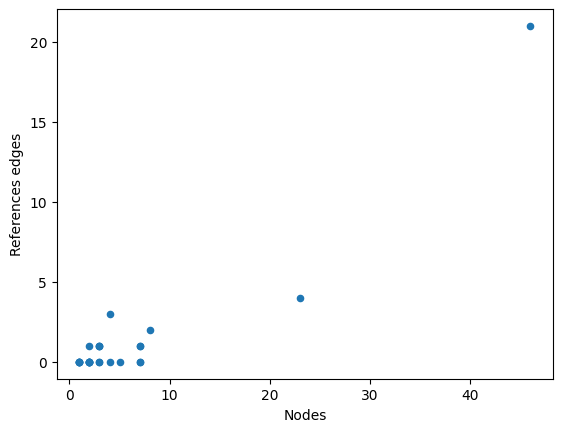

In [49]:
graph_info_df.plot(x = "Nodes", y = "References edges", kind = "scatter")

<Axes: xlabel='Nodes', ylabel='Concepts edges'>

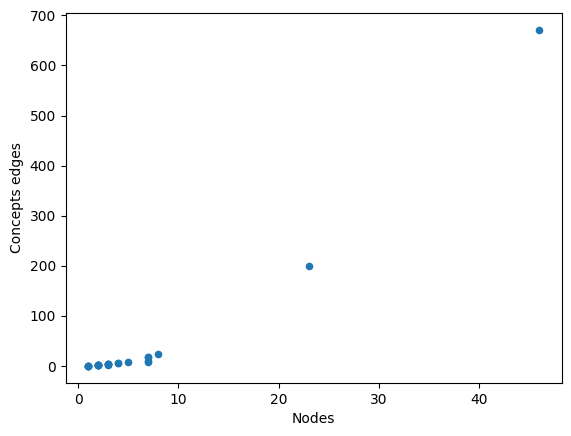

In [50]:
graph_info_df.plot(x = "Nodes", y = "Concepts edges", kind = "scatter")

<Axes: xlabel='Nodes', ylabel='Coauthors edges'>

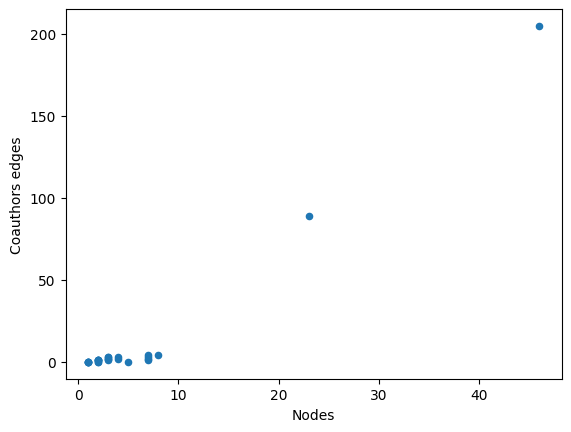

In [51]:
graph_info_df.plot(x = "Nodes", y = "Coauthors edges", kind = "scatter")

<Axes: xlabel='Nodes', ylabel='Institutions edges'>

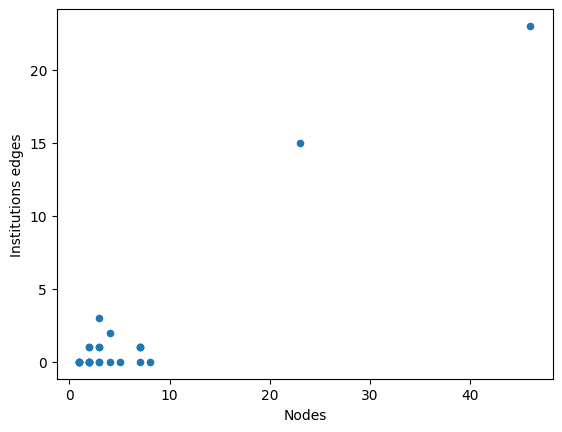

In [52]:
graph_info_df.plot(x = "Nodes", y = "Institutions edges", kind = "scatter")

<Axes: xlabel='Nodes', ylabel='Years edges'>

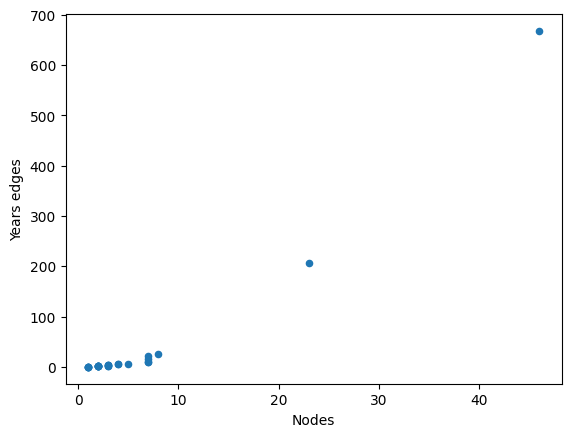

In [53]:
graph_info_df.plot(x = "Nodes", y = "Years edges", kind = "scatter")

In [144]:
x = np.array(graph_info_df["Nodes"])
y = np.array(graph_info_df["References edges"])
np.polyfit(x, np.log(y), 1, full=True)

(array([0.00852141, 2.02490686]),
 array([22.57951166]),
 2,
 array([1.22760804, 0.70212428]),
 5.10702591327572e-15)

In [145]:
x = np.array(graph_info_df["Nodes"])
y = np.array(graph_info_df["Concepts edges"])
np.polyfit(x, np.log(y), 1, full=True)

(array([0.02275951, 3.968799  ]),
 array([24.56179568]),
 2,
 array([1.22760804, 0.70212428]),
 5.10702591327572e-15)

In [147]:
x = np.array(graph_info_df["Nodes"])
y = np.array(graph_info_df["Coauthors edges"])
np.polyfit(x, np.log(y), 1, full=True)

(array([0.02266932, 2.73238245]),
 array([27.40859903]),
 2,
 array([1.22760804, 0.70212428]),
 5.10702591327572e-15)

In [149]:
x = np.array(graph_info_df["Nodes"])
y = np.array(graph_info_df["Institutions edges"])
np.polyfit(x, np.log(y), 1, full=True)

(array([0.01103238, 2.42641233]),
 array([25.9100464]),
 2,
 array([1.22760804, 0.70212428]),
 5.10702591327572e-15)

In [151]:
x = np.array(graph_info_df["Nodes"])
y = np.array(graph_info_df["Years edges"])
np.polyfit(x, np.log(y), 1, full=True)

(array([0.02295086, 3.61196847]),
 array([23.08581952]),
 2,
 array([1.22760804, 0.70212428]),
 5.10702591327572e-15)

In [154]:
def find_edges(nodes, exp1, exp2):
    return(math.exp(exp1)*math.exp(exp2*nodes))

In [237]:
nodes = [50, 500, 2000]
for node in nodes:
    print(find_edges(node, 3.612, 0.023))

116.97965139837879
3656437.97278213
3.5173682267831114e+21


Making graphs!

In [224]:
def make_random_graph(nodes, edges_list, mu):
    graphs_list = []
    cluster = 0
    cluster_dict = {}
    for node in range(nodes):
        cluster_dict[node] = cluster
        cluster += 1
        cluster = cluster % 4
    available_nodes_dict = {}
    for node in range(nodes):
        available_nodes_dict[node] = {}
        available_nodes_dict[node]["in"] = [x for x in range(nodes) if cluster_dict[x] == cluster_dict[node] and x != node]
        available_nodes_dict[node]["out"] = [x for x in range(nodes) if cluster_dict[x] != cluster_dict[node] and x != node]
    possible_edges = {"in": [], "out": []}
    nodes_list = list(range(nodes))
    for node1 in nodes_list:
        for node2 in nodes_list:
            if node2 in available_nodes_dict[node1]["in"]:
                possible_edges["in"].append([node1, node2])
                available_nodes_dict[node1]["in"].remove(node2)
                available_nodes_dict[node2]["in"].remove(node1)
            if node2 in available_nodes_dict[node1]["out"]:
                possible_edges["out"].append([node1, node2])
                available_nodes_dict[node1]["out"].remove(node2)
                available_nodes_dict[node2]["out"].remove(node1)
        nodes_list.remove(node1)
    for edges in edges_list:
        print(f'New graph with {nodes} nodes and {edges} edges')
        available_edges = possible_edges
        graph_edges = []
        in_count = round(edges*(1-mu))
        out_count = round(edges*mu)
        for j in range(in_count):
            if len(available_edges["in"]) != 0:
                edge = random.choice(available_edges["in"])
                graph_edges.append(edge)
                available_edges["in"].remove(edge)
        for k in range(out_count):
            if len(available_edges["out"]) != 0:
                edge = random.choice(available_edges["out"])
                graph_edges.append(edge)
                available_edges["out"].remove(edge)
        graph = igraph.Graph(n=nodes, edges = graph_edges)
        graphs_list.append(graph)
    return(graphs_list)

In [225]:
test_graphs = []
nodes = [10, 100, 1000, 10000]
edges = [[8, 66, 19, 13, 17], [18, 517, 149, 34, 136], [38000, 1000000, 1000000, 677400, 1000000], [1000000, 1000000, 1000000, 1000000, 1000000]]
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for j in range(10):
    for i in range(4):
        for mu in mus:
            print(nodes[i], mu)
            graph = make_random_graph(nodes[i], edges[i], mu)
            test_graphs.append([nodes[i], mu, graph])



10 0.1
New graph with 10 nodes and 8 edges
New graph with 10 nodes and 66 edges
New graph with 10 nodes and 19 edges
New graph with 10 nodes and 13 edges
New graph with 10 nodes and 17 edges
10 0.2
New graph with 10 nodes and 8 edges
New graph with 10 nodes and 66 edges
New graph with 10 nodes and 19 edges
New graph with 10 nodes and 13 edges
New graph with 10 nodes and 17 edges
10 0.3
New graph with 10 nodes and 8 edges
New graph with 10 nodes and 66 edges
New graph with 10 nodes and 19 edges
New graph with 10 nodes and 13 edges
New graph with 10 nodes and 17 edges
10 0.4
New graph with 10 nodes and 8 edges
New graph with 10 nodes and 66 edges
New graph with 10 nodes and 19 edges
New graph with 10 nodes and 13 edges
New graph with 10 nodes and 17 edges
10 0.5
New graph with 10 nodes and 8 edges
New graph with 10 nodes and 66 edges
New graph with 10 nodes and 19 edges
New graph with 10 nodes and 13 edges
New graph with 10 nodes and 17 edges
10 0.6
New graph with 10 nodes and 8 edges
Ne

KeyboardInterrupt: 

In [238]:
nodes = [50, 500, 2000]
edges = [[12, 166, 48, 20, 117], [536, 1000000, 1000000, 2768, 1000000], [1000000, 1000000, 1000000, 1000000, 1000000]] # CHANGE THESE
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for j in range(10):
    for i in range(3):
        for mu in mus:
            print(nodes[i], mu)
            graph = make_random_graph(nodes[i], edges[i], mu)
            test_graphs.append([nodes[i], mu, graph])



50 0.1
New graph with 50 nodes and 12 edges
New graph with 50 nodes and 166 edges
New graph with 50 nodes and 48 edges
New graph with 50 nodes and 20 edges
New graph with 50 nodes and 117 edges
50 0.2
New graph with 50 nodes and 12 edges
New graph with 50 nodes and 166 edges
New graph with 50 nodes and 48 edges
New graph with 50 nodes and 20 edges
New graph with 50 nodes and 117 edges
50 0.3
New graph with 50 nodes and 12 edges
New graph with 50 nodes and 166 edges
New graph with 50 nodes and 48 edges
New graph with 50 nodes and 20 edges
New graph with 50 nodes and 117 edges
50 0.4
New graph with 50 nodes and 12 edges
New graph with 50 nodes and 166 edges
New graph with 50 nodes and 48 edges
New graph with 50 nodes and 20 edges
New graph with 50 nodes and 117 edges
50 0.5
New graph with 50 nodes and 12 edges
New graph with 50 nodes and 166 edges
New graph with 50 nodes and 48 edges
New graph with 50 nodes and 20 edges
New graph with 50 nodes and 117 edges
50 0.6
New graph with 50 nodes

KeyboardInterrupt: 

In [248]:
nodes = [500]
edges = [[536, 1000000, 1000000, 2768, 1000000]] # CHANGE THESE
mus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for j in range(8):
    for i in range(1):
        for mu in mus:
            print(nodes[i], mu)
            graph = make_random_graph(nodes[i], edges[i], mu)
            test_graphs.append([nodes[i], mu, graph])

500 0.1
New graph with 500 nodes and 536 edges
New graph with 500 nodes and 1000000 edges
New graph with 500 nodes and 1000000 edges
New graph with 500 nodes and 2768 edges
New graph with 500 nodes and 1000000 edges
500 0.2
New graph with 500 nodes and 536 edges
New graph with 500 nodes and 1000000 edges
New graph with 500 nodes and 1000000 edges
New graph with 500 nodes and 2768 edges
New graph with 500 nodes and 1000000 edges
500 0.3
New graph with 500 nodes and 536 edges
New graph with 500 nodes and 1000000 edges
New graph with 500 nodes and 1000000 edges
New graph with 500 nodes and 2768 edges
New graph with 500 nodes and 1000000 edges
500 0.4
New graph with 500 nodes and 536 edges
New graph with 500 nodes and 1000000 edges
New graph with 500 nodes and 1000000 edges
New graph with 500 nodes and 2768 edges
New graph with 500 nodes and 1000000 edges
500 0.5
New graph with 500 nodes and 536 edges
New graph with 500 nodes and 1000000 edges
New graph with 500 nodes and 1000000 edges
New

In [326]:
def get_clusters(graph, resolution_parameter, weights = [1, 1, 1, 1, 1]):
    vertices = graph[0].vs
    partition = leidenalg.find_partition_multiplex(graph, leidenalg.CPMVertexPartition, layer_weights= weights, resolution_parameter = resolution_parameter)[0]
    dictionary = {}
    for i in range(len(partition)):
        if partition[i] in dictionary:
            dictionary[partition[i]].append(vertices[i]['_nx_name'])
        else:
            dictionary[partition[i]] = [vertices[i]['_nx_name']]
    return dictionary

In [338]:
print(test_graphs[0][2][0].vs[0])

igraph.Vertex(<igraph.Graph object at 0x7fc2a99f2040>, 0, {})


In [340]:
real_partitions = {10: [], 50: [], 100: [], 500: [], 1000: []}
for i in real_partitions:
    for j in range(i):
        real_partitions[i].append(j%4)
partition_results = pd.DataFrame(columns=["Nodes", "Mu", "Partition Type", "NMI"])
partition_types = [leidenalg.ModularityVertexPartition, leidenalg.CPMVertexPartition, leidenalg.RBERVertexPartition, leidenalg.RBConfigurationVertexPartition, leidenalg.SurpriseVertexPartition ]
for graph in test_graphs:
    for i in range(len(partition_types)):
        nodes = graph[0]
        mu = graph[1]
        partition_float = i
        print(nodes, mu, partition_float)
        partition = leidenalg.find_partition_multiplex(graph[2], partition_types[i], [1,1,1,1,1])[0]
        nmi = normalized_mutual_info_score(real_partitions[nodes], partition)
        partition_results.loc[len(partition_results)] = [nodes, mu, partition_float, nmi]


10 0.1 0
10 0.1 1
10 0.1 2
10 0.1 3
10 0.1 4
10 0.2 0
10 0.2 1
10 0.2 2
10 0.2 3
10 0.2 4
10 0.3 0
10 0.3 1
10 0.3 2
10 0.3 3
10 0.3 4
10 0.4 0
10 0.4 1
10 0.4 2
10 0.4 3
10 0.4 4
10 0.5 0
10 0.5 1
10 0.5 2
10 0.5 3
10 0.5 4
10 0.6 0
10 0.6 1
10 0.6 2
10 0.6 3
10 0.6 4
10 0.7 0
10 0.7 1
10 0.7 2
10 0.7 3
10 0.7 4
10 0.8 0
10 0.8 1
10 0.8 2
10 0.8 3
10 0.8 4
10 0.9 0
10 0.9 1
10 0.9 2
10 0.9 3
10 0.9 4
100 0.1 0
100 0.1 1
100 0.1 2
100 0.1 3
100 0.1 4
100 0.2 0
100 0.2 1
100 0.2 2
100 0.2 3
100 0.2 4
100 0.3 0
100 0.3 1
100 0.3 2
100 0.3 3
100 0.3 4
100 0.4 0
100 0.4 1
100 0.4 2
100 0.4 3
100 0.4 4
100 0.5 0
100 0.5 1
100 0.5 2
100 0.5 3
100 0.5 4
100 0.6 0
100 0.6 1
100 0.6 2
100 0.6 3
100 0.6 4
100 0.7 0
100 0.7 1
100 0.7 2
100 0.7 3
100 0.7 4
100 0.8 0
100 0.8 1
100 0.8 2
100 0.8 3
100 0.8 4
100 0.9 0
100 0.9 1
100 0.9 2
100 0.9 3
100 0.9 4
1000 0.1 0
1000 0.1 1
1000 0.1 2
1000 0.1 3
1000 0.1 4
1000 0.2 0
1000 0.2 1
1000 0.2 2
1000 0.2 3
1000 0.2 4
1000 0.3 0
1000 0.3 1
1000 0.3 2
10

In [341]:
print(partition_results)

      Nodes   Mu  Partition Type       NMI
0      10.0  0.1             0.0  0.524117
1      10.0  0.1             1.0  0.744756
2      10.0  0.1             2.0  0.379605
3      10.0  0.1             3.0  0.524117
4      10.0  0.1             4.0  0.682508
...     ...  ...             ...       ...
1845  500.0  0.9             0.0  0.022241
1846  500.0  0.9             1.0  0.364771
1847  500.0  0.9             2.0  0.294142
1848  500.0  0.9             3.0  0.000000
1849  500.0  0.9             4.0  0.124228

[1850 rows x 4 columns]


<Axes: xlabel='Nodes', ylabel='NMI'>

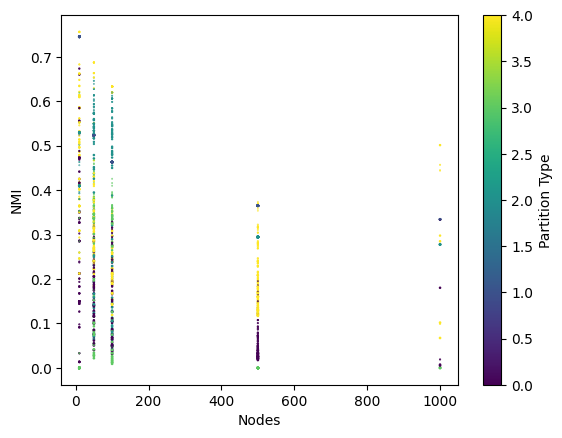

In [342]:
partition_results.plot.scatter(x = "Nodes", y = "NMI", s = "Mu", c = "Partition Type")

In [56]:
authors_for_testing = combine(author_info)

In [57]:
graph_for_testing = create_graph(authors_for_testing)

In [58]:
len(authors_for_testing.listofIDs)

152

In [59]:
def choose_resolution_parameter(graph):
    current_clusters = len(list(get_clusters(graph, 0).keys()))
    cluster_difference = 0
    rp_range = [0, 0]
    i = 0.1
    while i < 1:
        print(f'testing rp = {i}, current rp range = {rp_range}')
        part = get_clusters(graph, i)
        new_clusters = len(list(part.keys()))
        new_diff = new_clusters - current_clusters
        print(f'clusters count: {new_clusters}, difference: {new_diff}')
        if new_diff > cluster_difference:
            rp_range = [round(i - 0.1, 1), round(i, 1)]
            cluster_difference = new_diff
        elif new_diff == cluster_difference and round(i - 0.1, 1) == rp_range[1]:
            rp_range[1] = i
        current_clusters = new_clusters
        i += 0.1
    best_rp = rp_range[0]
    current_clusters = len(list(get_clusters(graph, best_rp).keys()))
    cluster_difference = 0
    j = best_rp + 0.01
    while j <= rp_range[1] + 0.01:
        print(f'testing rp = {j}, current best rp = {best_rp}')
        part = get_clusters(graph, j)
        new_clusters = len(list(part.keys()))
        new_diff = new_clusters - current_clusters
        print(f'clusters count: {new_clusters}, difference: {new_diff}')
        if new_diff > cluster_difference:
            best_rp = round(j-0.01, 2)
            cluster_difference = new_diff
        current_clusters = new_clusters
        j += 0.01
    return best_rp

In [60]:
choose_resolution_parameter(graph_for_testing)

testing rp = 0.1, current rp range = [0, 0]
clusters count: 7, difference: 0
testing rp = 0.2, current rp range = [0, 0.1]
clusters count: 11, difference: 4
testing rp = 0.30000000000000004, current rp range = [0.1, 0.2]
clusters count: 23, difference: 12
testing rp = 0.4, current rp range = [0.2, 0.3]
clusters count: 59, difference: 36
testing rp = 0.5, current rp range = [0.3, 0.4]
clusters count: 84, difference: 25
testing rp = 0.6, current rp range = [0.3, 0.4]
clusters count: 101, difference: 17
testing rp = 0.7, current rp range = [0.3, 0.4]
clusters count: 110, difference: 9
testing rp = 0.7999999999999999, current rp range = [0.3, 0.4]
clusters count: 122, difference: 12
testing rp = 0.8999999999999999, current rp range = [0.3, 0.4]
clusters count: 125, difference: 3
testing rp = 0.9999999999999999, current rp range = [0.3, 0.4]
clusters count: 152, difference: 27
testing rp = 0.31, current best rp = 0.3
clusters count: 23, difference: 1
testing rp = 0.32, current best rp = 0.3

0.39

In [61]:
part = get_clusters(graph_for_testing, 0.39, [0.35, -0.05, 0.25, 0.5, -0.05])

In [62]:
part2 = get_clusters(graph_for_testing, 0.39)

In [319]:
part3 = get_clusters(graph_for_testing, 0.01)

In [63]:
find_uniformity(author_info, part)

0.7082115009746582

In [64]:
find_uniformity(author_info, part2)

0.16648391812865487

In [69]:
find_best_weights(author_info, graph_for_testing, 0.39, [0.2, 0.2, 0.2, 0.2, 0.2])

0.25 0.15000000000000002 0.2 0.2 0.2
0.25 0.15000000000000002 0.2 0.25 0.15000000000000002
0.25 0.10000000000000002 0.2 0.25 0.2
0.3 0.10000000000000002 0.15000000000000002 0.25 0.2
0.3 0.05000000000000002 0.15000000000000002 0.3 0.2
0.35 1.3877787807814457e-17 0.15000000000000002 0.3 0.2
0.35 -0.04999999999999999 0.15000000000000002 0.3 0.25
0.35 -0.09999999999999999 0.15000000000000002 0.35 0.25
0.39999999999999997 -0.15 0.15000000000000002 0.35 0.25
0.44999999999999996 -0.2 0.15000000000000002 0.35 0.25
0.44999999999999996 -0.2 0.10000000000000002 0.39999999999999997 0.25
0.44999999999999996 -0.2 0.10000000000000002 0.44999999999999996 0.2
0.49999999999999994 -0.25 0.10000000000000002 0.44999999999999996 0.2
0.49999999999999994 -0.25 0.10000000000000002 0.49999999999999994 0.15000000000000002
0.5499999999999999 -0.3 0.10000000000000002 0.49999999999999994 0.15000000000000002
0.5499999999999999 -0.35 0.10000000000000002 0.5499999999999999 0.15000000000000002
0.6 -0.35 0.1000000000000

RecursionError: maximum recursion depth exceeded